## Линейная регрессия

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

#### Простая линейная регрессия

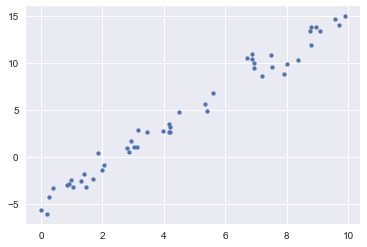

In [2]:
# У нас есть данные
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y, s=15);

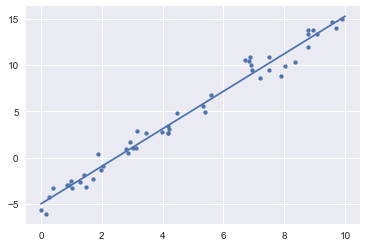

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y, s=15)
plt.plot(xfit, yfit);

In [4]:
# Подбираемые параметры модели всегда содержат в концу знак подчеркивания.
print('Угловой коэффициент  : ', model.coef_[0])
print('Точка пересечения с y:', model.intercept_)
# Как мы видим результаты близки как мы и надеялись

Угловой коэффициент  :  2.0272088103606953
Точка пересечения с y: -4.998577085553204


Однаков возможности оценивателя LinearRegression намного шире этого: помимо апроксимации прямыми линиями, он может также работать с многомерными линейными моделями следующего вида:
> $y = a_0 + a_1x_1 + a_2x_2 + ...$

с несколькими величинами x. Геометрически это подобно подбору плоскости для точек в трех измерениях или гиперплоскости для точек в пространстве с большим количеством измерений.
 
Многомерная сущность подобных регрессий усложняет их визуализацию, но мы можем посмотреть на одну из этих аппроксимаций в действии, создав данные для нашего примера с помощью оператора матричного умножения из библиотеки Numpy:

In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_.round(1))
print(model.coef_)

0.5
[ 1.5 -2.   1. ]


Здесь данные величины $y$ сформированы из трех случайных значений величины x, а линейная регрессия востанавливает использовавшиеся для их формирования коэффициенты.

#### Регрессия по комбинации базисных пунктов

Идея состоит в том, чтобы взять многомерную линейную модель:
>$y = a_0 + a_1x_1 + a_2x_2 + ...$

и построить $x_1$, $x_2$ и т.д. на основе имеющегося одномерного входного значения $x$. То есть у нас $x_n = f_n(x)$, где $f_n(x)$ - некая функция выполняющая преобразование данных.
Например, если $f_n(x) = x^n$, наша модель превращается в полиноминальную регрессию:
>$y = a_0 + a_1x + a_2x^2 + ...$

Фактически мы взяли наши одномерные значения $x$ и выполнили проекцию их на более многомерное пространство, так что с помощью линейной аппроксимации мы можем теперь отражать более сложные зависимости между $x$ и $y$.

#### Полиноминальные базисные функции

Данная проекция настолько удобна, что была встроена в библиотека Scikit-learn в виде преобразователя PolynomialFeatures:

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression()) 
# можно выстроить такой конвейер 

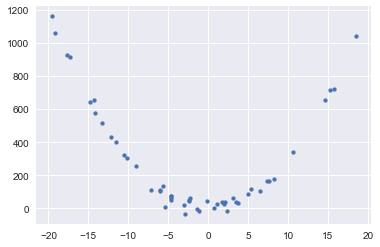

In [7]:
%matplotlib inline
# Создадим набор данных в виде пораболлы 
rng = np.random.RandomState(42)
x = 10 * rng.randn(50)
y = 3 * x ** 2 + 30 * rng.randn(50)

plt.scatter(x, y, s=15);

<IPython.core.display.Javascript object>


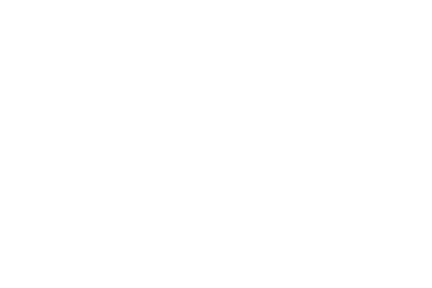

<IPython.core.display.Javascript object>


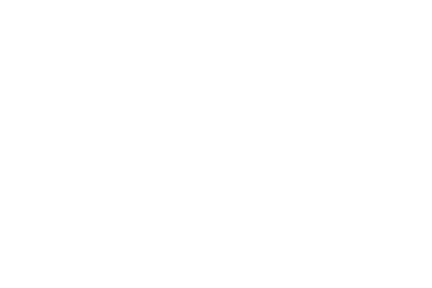

In [8]:
%matplotlib notebook

# import pylab # интересно что за pylab(нашел в примере в интернете)

from mpl_toolkits.mplot3d import Axes3D
poly = PolynomialFeatures(2, include_bias=False)
x_poly = poly.fit_transform(x[:, None])
fig = plt.figure()
axes = Axes3D(fig)

xfit = np.linspace(-20, 20, 20)

xfit_poly = poly.fit_transform(xfit[:, None])

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

axes.scatter(x_poly[:, 0], x_poly[:, 1], y, c='r')

axes.plot(xfit_poly[:, 0], xfit_poly[:, 1], yfit, c='y')          
axes.scatter(xfit_poly[:, 0], xfit_poly[:, 1], yfit, c='g', s=50) # зеленые точки сгененрированы моделью
axes.plot_wireframe(xfit_poly[:, 0], xfit_poly[:, 1, np.newaxis], yfit[:, np.newaxis]); # строится на основании зеленых точек
# plt.show()

При проекции данного графика на изначальную плоскость от $x, y$ получаем график полиномиальной регрессии сделанный с помощью линейной регрессии.

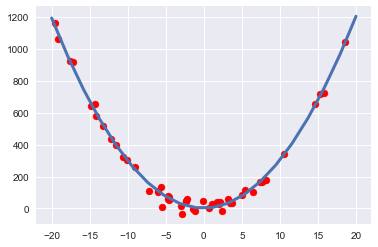

In [9]:
%matplotlib inline
plt.scatter(x, y, c='r')
plt.plot(xfit, yfit, linewidth=3);

С нашей линейной моделью, используя полиномиальные базисные функции седьмого порядка, мы получили великолепную апроксимацию этих нелинейных данных.

#### Гауссовы базисные функции

Гауссовы базисные функции не встроены в библиотеку Scikit-learn, но можно написать собственный преобразователь.

In [10]:
import pandas as pd

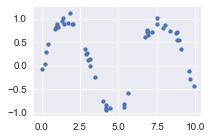

In [11]:
# Создадим новую более сложную выборку
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
fig = plt.figure(figsize=(3, 2))
plt.scatter(x, y, s=15);

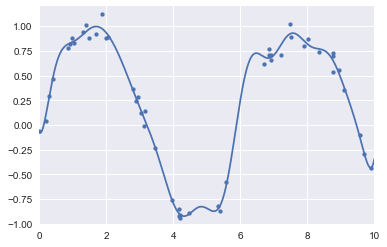

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class Gaussianfeatures(BaseEstimator, TransformerMixin):
    '''Равномерно распределенные Гаусовы признаки
       для одномерных входных данных'''
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # Создаем N центров распределенных по всему диапазону данных
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)
    
gauss_model = make_pipeline(Gaussianfeatures(20),
                            LinearRegression())

xfit = np.linspace(0, 10, 1000)
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y, s=15)
plt.plot(xfit, yfit)
plt.xlim(0, 10)
plt.ylim(-1, 1.2);

#### Регуляризация

Применение базисных функций в нашей линейной модели делает ее намного гибче, но также и быстро приводит к переобучению. Например, если выбрать слишком много Гауссовых базисных функций, мы в итоге получим не слишком хорошие результаты:

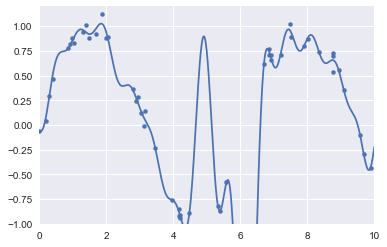

In [13]:
model = make_pipeline(Gaussianfeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y, s=17)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))
plt.xlim(0, 10)
plt.ylim(-1, 1.2);

В результате проекции данных на 30-мерный базис модель оказалась слишком гибкой и стремится к экстремальным значениям в промежутках между точками, которыми она ограничена. Причину этого можно понять, построив график коэффициентов Гауссовых базисных функций в соответствии с координатой $x$:

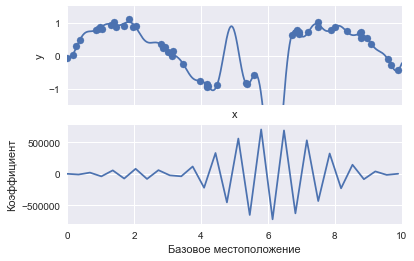

In [14]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_)
    ax[1].set(xlabel='Базовое местоположение', ylabel='Коэффициент', xlim=(0, 10))
    
model = make_pipeline(Gaussianfeatures(30), LinearRegression())
basis_plot(model)

Нижняя часть демонстрирует амплитуду базисной функции в каждой из точек. Это типичное поведение для переобучения с перекрытием областей определения базисных функций: коэффициенты соседних базисных функций усиливают друг друга. Мы знаем, что подобное поведение приводит к проблемам и было бы неплохо ограничивать подобные пики в модели явным образом, "накладывать штраф" на большие значения параметров модели. Такое "Штрафование" известно под названием **регуляризации** и существует в нескольких вариантах.

#### Гребневая регрессия (L$_2$- регуляризация)

Вероятно, самый часто встречающийся вид регуляризации, также иногда называемая *регуляризацией Тихонова*. Она заключается в наложении штрафа на сумму квадратов коэффициентов модели. В данном случае штраф модели будет равен:
> $P = \alpha\sum^N_{n=1} \theta^2_n$

где $\alpha$ - свободный параметр, служащий для управления уровнем штрафа. Этот тип модели со штрафом встроен в библиотеку Scikit-learn в виде оценивателя Ridge.

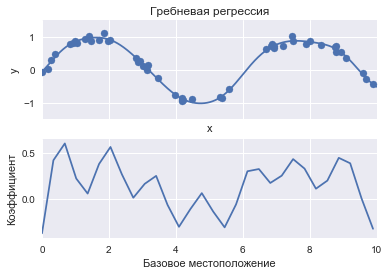

In [15]:
from sklearn.linear_model import Ridge
model = make_pipeline(Gaussianfeatures(30), Ridge(alpha=0.01))
basis_plot(model, title='Гребневая регрессия')

Параметр $\alpha$ служит для управления сложностью получаемой в итоге модели. В предельном лучае $\alpha \rightarrow 0$ мы получаем результат, соответствующий  стандартной линейной регрессии; в предельном случае $\alpha \rightarrow \infty$ будет происходить подавление любого отклика модели. Достоинства гребневой регрессии включают - вычислительные затраты практически не превышают затрат на расчет исходной линейной регрессионной модели.

#### Лассо-регуляризация( L$_1$)

Еще один распространненый тип регуляризации-так называемая лассо-регуляризация, включающая штрафование на сумму абсолютных   значений ($L_1$-норма) коэффициент регрессии:
> $P=\alpha\sum_{n=1}^N|\theta_N|$

Хотя концептуально эта регрессия очень близка к гребневой, результаты их могут очень сильно различаться. Например, по геометрическим причинам *лассо-регрессия* любит *разреженные модели*, то есть она по возможности делает коэффициенты модели равными нулю.

Воспроизведем график, но с использованием коэффициентов, нормализованных с помощью нормы L$_1$:

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


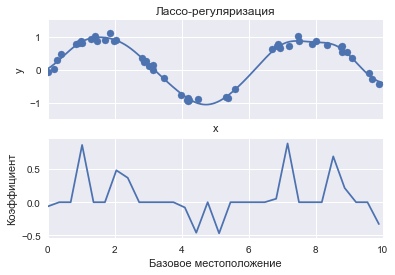

In [16]:
from sklearn.linear_model import Lasso
model = make_pipeline(Gaussianfeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Лассо-регуляризация')

При использовании штрафа лассо-регрессии большинство коэффициентов в точности равно нулю, а функциональное поведение моделируется небольшим множеством из имеющихся базисных функций. Как и в случае гребневой регуляризации, параметр управляет уровнем штрафа и его следует определять путем перекрестной проверки.

#### Пример: предсказание велосипедного трафика

In [17]:
counts = pd.read_csv('sns/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('sns/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [18]:
# Далее вычислим ежедневный поток велосипед
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # Удаляем остальные столбцы

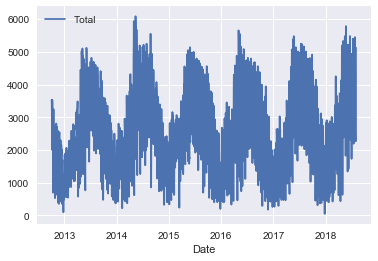

In [19]:
daily.plot();

In [20]:
# мы видели что использование велосипедов изменяется день ото дня. Учтем это
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [21]:
# Следует ожидать что велосипедисты будут вести себя иначе по выходным
# Добавим индикатор для этого
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [22]:
# Логично предположить, что свое влияние на кол-во велосипедистов окажет и световой день.
# Воспоьзуемся астрономическими расчетами для добавления информации
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    '''Рассчитаем длительность светового дня для заданной даты'''
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) *
                  np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))

In [23]:
# Добавляем сред. температуру, общее кол-во осадков и флаг обозначающий засушливые дни(кол-во осадков 0)
# Кол-во осадков указано в десятых долях градуса Цельсия
# Преобразуем в градусы
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp(C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# Преобразуем осадки в миллиметры
weather['PRCP'] /= 10
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp(C)', 'dry day']])

In [24]:
# Счетчик, который будет увеличиваться начиная с первого дня, и отмерять количество прошедших лет.
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [25]:
# теперь посмотрим на наши данные
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp(C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [26]:
daily.dropna(axis=0, how='any', inplace=True)
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 
                'daylight_hrs', 'PRCP', 'dry day', 'Temp(C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

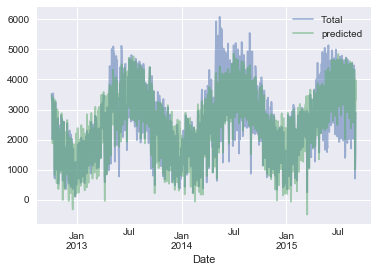

In [28]:
daily[['Total', 'predicted']].plot(alpha=0.5);

Очевидно, что упущены какие-то ключевые признаки, особенно летом. Или список наших признаков неполон(Люди принимают решение ехать или не ехать на велосипеде основываясь не только на них), или имеются какие-то нелинейные зависимости, которые мы не учли(например, возможно, люди ездят реже в жару и в холод). Тем не менее эта грубая аппроксимация дает неков представление о данных, и мы можем посмотреть на коэфициенты линейной модели, чтобы оценить какой вклад вносит в ежедневное кол-во поездок на велосипедах, каждый из признаков. 

In [29]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP             -26.174602
dry day          547.698592
Temp(C)           65.162791
annual            26.942713
dtype: float64

Эти числа нелегко интепретировать в отсутствии меры их погрешности. Быстро вычислить погрешности можно путем бутстрэппинга - повторных выборок данных:

In [31]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [35]:
pd.options.display.float_format = '{:20,.2f}'.format

In [36]:
print(pd.DataFrame({'Эффект': params.round(0), 'Ошибка': err.round(0)}))

                           Эффект               Ошибка
Mon                           505                   86
Tue                           610                   83
Wed                           593                   83
Thu                           482                   85
Fri                           178                   81
Sat                        -1,103                   80
Sun                        -1,134                   83
holiday                    -1,187                  163
daylight_hrs                  129                    9
PRCP                          -26                    2
dry day                       548                   33
Temp(C)                        65                    4
annual                         27                   18


* Прежде всего видно, что существует довольно устойчивая тенденция относительно еженедельного минимума - по будням велосипедистов намного больше чем в выходные и праздники. 
* с каждым дополнительным часом светлого времени суток велосипедистов становится больше на 129$\pm$9;
* рост температуры на 1 градус Цельсия стимулирует 65$\pm$4 человек взяться за велосипедв 
* сухой день - +546$\pm$33 велосипедистов
* каждый дюйм осадков - -665$\pm$62 велосипедистов

После учета всех влияний получается умеренный рост +28$\pm$18 человек в год

Этой модели наверняка не достает информации: нелинейные влияния(совместное влияние осадков и низкой температуры) и нелинейные тренды в пределах каждой из переменных (нежелание ездить на велосипедах в очень холодную и жаркую погоду) не могут быть учтены в данной модели. Кроме того, мы отбросили некоторые нюансы (такие как различие между дождливым утром и дождливым полуднем), а также проигнорировали корреляции между днями(возможное влияние дождливого вторника на показатели среды или влияние внезапного солнечного после полосы дождей).